In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

pysindy_path = r'C:\Users\phili\PycharmProjects\pysindy'

# 1D KdV equation with one soliton

In [2]:
c = 1
nx, nt = (300, 200)
x = np.linspace(0, 10, nx)
t = np.linspace(0, 10, nt)
tv, xv = np.meshgrid(t, x)

u = c/2*np.cosh(np.sqrt(c)/2*(xv-c*tv))**(-2)

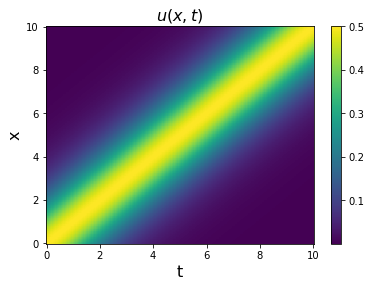

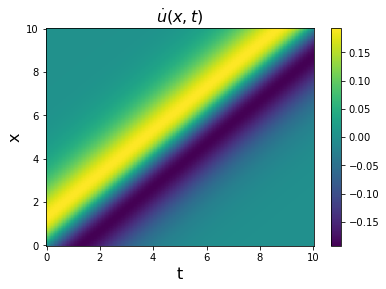

In [3]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

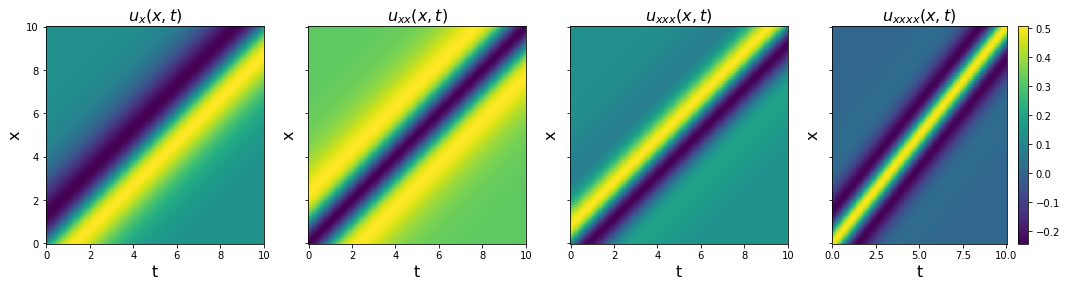

In [4]:
dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0,
                          drop_endpoints=False)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0,
                           drop_endpoints=False)._differentiate(u, dx)
uxxxx = ps.FiniteDifference(d=4, axis=0,
                            drop_endpoints=False)._differentiate(u, dx)

# Plot derivative results
plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.pcolormesh(t, x, ux)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u_x(x, t)$', fontsize=16)
plt.subplot(1, 4, 2)
plt.pcolormesh(t, x, uxx)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 3)
plt.pcolormesh(t, x, uxxx)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 4)
plt.pcolormesh(t, x, uxxxx)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxxx}(x, t)$', fontsize=16)
plt.colorbar()
plt.show()

In [5]:
u = u.reshape(len(x), len(t), 1)

# Define PDE library that is quadratic in u, and
# third-order in spatial derivatives of u.
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3, spatial_grid=x,
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = -1.000 x0_1
SR3 model, L0 norm: 
(x0)' = -1.000 x0_1
SR3 model, L1 norm: 
(x0)' = -1.000 x0_1
SSR model: 
(x0)' = -1.000 x0_1 + 0.001 x0x0_1
SSR (metric = model residual) model: 
(x0)' = -1.000 x0_1
FROLs model: 
(x0)' = 0.000


In [6]:
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

(x0)' = -1.000 x0_1


In [7]:
optimizer.history_

[array([[ 9.27293641e-16, -1.12694817e-09,  3.38100655e-09,
         -9.92723945e-01,  1.12677686e-09, -7.50303235e-03,
          1.30965827e-01,  1.68024976e-12, -1.74644655e-01,
         -1.04826007e+00, -1.22146426e-12, -5.27198280e-04]]),
 array([[ 0.        ,  0.        ,  0.        , -0.80993411,  0.        ,
         -0.19026662, -0.9972012 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        , -0.82523412,  0.        ,
          0.        , -1.04887721,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        , -1.00015201,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        , -0.99981152,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]])]

# Exponential function: $u(t,x)=exp(x-at)$

We have here that $u$ solves $u_t = -a u_x$ and $u_t= -a u$.

In [8]:
a = 3
nx, nt = (300, 200)
x = np.linspace(0, 10, nx)
t = np.linspace(0, 10, nt)
tv, xv = np.meshgrid(t, x)

u = np.exp(xv-a*tv)

dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)

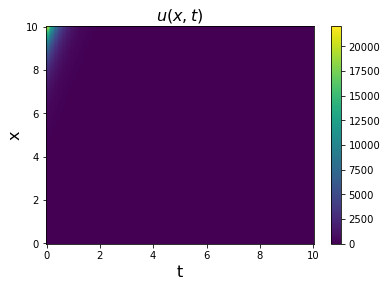

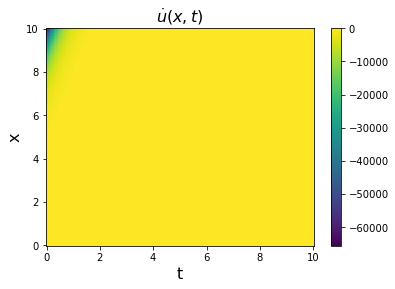

In [9]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

In [10]:
u = u.reshape(len(x), len(t), 1)

# Define PDE library that is quadratic in u, and
# third-order in spatial derivatives of u.
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=1, spatial_grid=x,
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 0.143 1 + -15.268 x0 + 12.250 x0_1
SR3 model, L0 norm: 


D:\programs\miniconda3\envs\tf-gpu\envs\pysindy\lib\site-packages\pysindy\optimizers\sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


(x0)' = 0.143 1 + -15.268 x0 + 12.250 x0_1
SR3 model, L1 norm: 
(x0)' = 0.143 1 + -15.268 x0 + 12.250 x0_1
SSR model: 
(x0)' = -15.254 x0 + 12.235 x0_1
SSR (metric = model residual) model: 
(x0)' = -0.308 1 + -3.052 x0 + 0.049 x0_1
FROLs model: 
(x0)' = -3.003 x0


D:\programs\miniconda3\envs\tf-gpu\envs\pysindy\lib\site-packages\pysindy\optimizers\sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


In [11]:
model.coefficients()

array([[ 0.        , -3.00312357,  0.        ,  0.        ]])

# Now find a way to show beforehand that there are other polynomials fitting this data

In [12]:
import torch
from torch import Tensor
from torch.nn import Linear, MSELoss, functional as F
from torch.optim import SGD, Adam, RMSprop
from torch.autograd import Variable
import numpy as np

device = torch.device("cpu")

ModuleNotFoundError: No module named 'torch'

In [ ]:
u = u.squeeze()

In [ ]:
# feature_matrix = torch.tensor(np.stack([torch.ones(u.shape), u, ux, uxx, uxxx, uxxxx, u*u, u*ux, u*uxx, u*uxxx, u*uxxxx]), dtype=torch.float32)
feature_matrix = torch.tensor(np.stack([torch.ones(u.shape), u, ux]), dtype=torch.float32)

In [ ]:
coeffs = torch.ones(feature_matrix.shape[0], dtype=torch.float32, device=device, requires_grad=True)
optimizer = torch.optim.Adam([coeffs], lr=0.001)

In [ ]:
n_steps = 5000
non_zero_lambda = 10
zero_lambda = 1
for step in range(n_steps):
    regularization =  zero_lambda * torch.norm(coeffs) + non_zero_lambda * 1 / torch.norm(coeffs)
    error = torch.norm(torch.inner(coeffs, feature_matrix.T)) * 1 / np.prod(u.shape)
    loss = error + regularization
    # Perform optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 500 == 0:
        print(error)

In [ ]:
coeffs

In [ ]:
goal_coeffs = torch.tensor([0, 1, -1], dtype=torch.float32, device=device, requires_grad=False)

In [ ]:
torch.norm(torch.inner(goal_coeffs, feature_matrix.T)) / np.prod(u.shape)

In [ ]:
np.linalg.norm(u - ux, ord='fro') / np.prod(u.shape)

In [ ]:
np.linalg.norm(u_dot + a * ux) / np.prod(u.shape)

# Next step: Projected gradient descent

In [ ]:
coeffs = torch.ones(feature_matrix.shape[0], dtype=torch.float32, device=device, requires_grad=True)
optimizer = torch.optim.SGD([coeffs], lr=0.001)

In [ ]:
n_steps = 5000
non_zero_lambda = 10
zero_lambda = 1
for step in range(n_steps):
    error = torch.norm(torch.inner(coeffs, feature_matrix.T)) * 1 / np.prod(u.shape)
    loss = error
    # Perform optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        coeffs = torch.tensor(coeffs / torch.norm(coeffs), dtype=torch.float32, device=device, requires_grad=True)
    if step % 500 == 0:
        print(error)

In [ ]:
coeffs

In [ ]:
test_coeffs = np.stack([np.linspace(0,1,100), 0.577*np.ones(100), 0.577*np.ones(100)])

In [ ]:
test_errors = np.linalg.norm(np.dot(feature_matrix.numpy().T, test_coeffs), axis=(0,1)) * 1 / np.prod(u.shape)

In [ ]:
test_errors.shape

In [ ]:
plt.plot(test_errors)

This shows that actually the problem here is that the gradient will directly point to 0 for $u$ and $u_x$, so neiter of them will be changed as the new value is always mapped again to the unit circle.

## What happens if we fix one value to be 1?

In [ ]:
coeffs = torch.ones(feature_matrix.shape[0]-1, dtype=torch.float32, device=device, requires_grad=True)

In [ ]:
torch.inner(coeffs, feature_matrix.T[:,:,:-1]).shape

In [ ]:
n_steps = 5000
non_zero_lambda = 10
zero_lambda = 1
for step in range(n_steps):
    error = torch.norm(torch.inner(coeffs, feature_matrix.T[:,:,:-1]) + feature_matrix.T[:,:,-1]) * 1 / np.prod(u.shape)
    loss = error
    # Perform optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        coeffs = torch.tensor(coeffs / torch.norm(coeffs), dtype=torch.float32, device=device, requires_grad=True)
    if step % 500 == 0:
        print(error)

In [ ]:
coeffs

In [ ]:
x = np.linspace(0,1,100)
mesh = np.array(np.meshgrid(x,x))

In [ ]:
mesh.shape

In [ ]:
mesh[:,1,1]

In [ ]:
np.einsum(feature_matrix.numpy(), mesh)

In [ ]:
np.dot(feature_matrix.numpy().T, mesh.T)

In [ ]:
losslandscape = np.linalg.norm(np.dot(feature_matrix.numpy().T, mesh), axis=(0,1)) * 1 / np.prod(u.shape)

In [ ]:
torch.inner(coeffs, feature_matrix.T)

In [ ]:
model.score(x,u,t=dt)

In [ ]:
model.n_input_features_

In [ ]:
print('Model score: %f' % model.score(x, t=dt))